In [2]:
# Install repo
!pip3 install -e .
!pip3 install -r requirements.txt

Obtaining file:///home/gberseth/playground/octo-mini
ERROR: file:///home/gberseth/playground/octo-mini does not appear to be a Python project: neither 'setup.py' nor 'pyproject.toml' found.


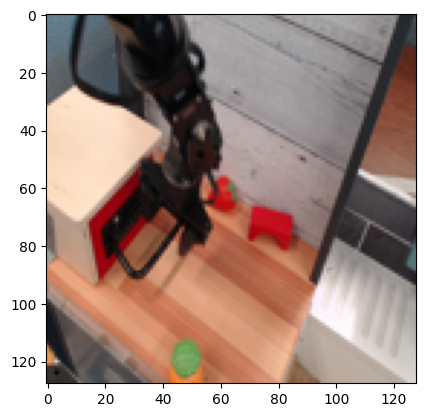

In [3]:
from PIL import Image
import requests
import matplotlib.pyplot as plt
import numpy as np

# download one example BridgeV2 image
IMAGE_URL = "https://rail.eecs.berkeley.edu/datasets/bridge_release/raw/bridge_data_v2/datacol2_toykitchen7/drawer_pnp/01/2023-04-19_09-18-15/raw/traj_group0/traj0/images0/im_12.jpg"
img = np.array(Image.open(requests.get(IMAGE_URL, stream=True).raw).resize((128, 128)))
plt.imshow(img)

In [ ]:
## Get full trajectories
Instead of a single image we want something that looks more like a sequence, similar to text. 
For robotics applications our langauge is images and actions.

In [4]:
!pip install rlds dm-reverb mediapy 
!pip install opencv-python ## for cv2
!pip install tensorflow==2.15.0
!pip install tensorflow_datasets==4.9.2
!pip install moviepy>=1.0.3
#import os
#os.environ['JAX_PLATFORMS'] = 'cpu' # Force on CPU

import cv2
# import jax
# import tensorflow as tf
import tensorflow_datasets as tfds
import tqdm
import rlds, numpy as np
import mediapy as media
from PIL import Image
from IPython import display

/home/gberseth/anaconda3/envs/roble/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-07-21 07:48:15.909831: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-21 07:48:15.909913: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-21 07:48:15.940134: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-21 07:48:16.005367: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlo

## Load Datasets

The data for robotics applications is often more complicated. There are images, actions and text descriptions. Also, the text descriptions is per episode, instead of at each frame, which is common for RL/BC.

In [9]:
# create RLDS dataset builder
builder = tfds.builder_from_directory(builder_dir='gs://gresearch/robotics/bridge/0.1.0/')
dataset = builder.as_dataset(split='train[:1]')

# sample episode + resize to 256x256 (default third-person cam resolution)
episode = next(iter(dataset))
print(episode)

steps = list(episode['steps'])
images = np.array([cv2.resize(np.array(step['observation']['image']), (256, 256)) for step in steps])

# extract goal image & language instruction
goal_image = images[-1]
language_instruction = steps[0]['observation']['natural_language_instruction'].numpy().decode()

# visualize episode
print(f'Instruction: {language_instruction}')
# media.show_video(images, fps=10)

{'steps': <_VariantDataset element_spec={'action': {'open_gripper': TensorSpec(shape=(), dtype=tf.bool, name=None), 'rotation_delta': TensorSpec(shape=(3,), dtype=tf.float32, name=None), 'terminate_episode': TensorSpec(shape=(), dtype=tf.float32, name=None), 'world_vector': TensorSpec(shape=(3,), dtype=tf.float32, name=None)}, 'is_first': TensorSpec(shape=(), dtype=tf.bool, name=None), 'is_last': TensorSpec(shape=(), dtype=tf.bool, name=None), 'is_terminal': TensorSpec(shape=(), dtype=tf.bool, name=None), 'observation': {'image': TensorSpec(shape=(480, 640, 3), dtype=tf.uint8, name=None), 'natural_language_embedding': TensorSpec(shape=(512,), dtype=tf.float32, name=None), 'natural_language_instruction': TensorSpec(shape=(), dtype=tf.string, name=None), 'state': TensorSpec(shape=(7,), dtype=tf.float32, name=None)}, 'reward': TensorSpec(shape=(), dtype=tf.float32, name=None)}>}
Instruction: Place the can to the left of the pot.


In [7]:
# sample episode + resize to 256x256 (default third-person cam resolution)

# read it in to inspect it
# robot_text = open('goal_action_info.txt', 'w', encoding='utf-8') 

import numpy as np
for episode in dataset:
    steps = list(episode['steps'])
    true_action = np.concatenate((
            np.array(steps[0]['action']['world_vector']).astype(np.float32),
            np.array(steps[0]['action']['rotation_delta']).astype(np.float32),
            np.array(steps[0]['action']['open_gripper']).astype(np.float32)[None]
        ), axis=-1
    )
    goal = steps[0]['observation']['natural_language_instruction'].numpy().decode()
    line = str(goal) + ": " + str(true_action) + "\n"
    print (line)
    # robot_text.write(line)
# robot_text.close()

Place the can to the left of the pot.: [ 1.9514002e-10  8.0674190e-11  2.9859176e-10  6.0771669e-07
 -1.1930091e-07  1.3083890e-07  1.0000000e+00]



In [14]:
## Get patches for images
import torch
n_patches = 8
print("patches", images.shape)
batch_size, height, width, channels = images.shape
assert height == width, "Patchify method is implemented for square images only"

patches = np.zeros(batch_size, n_patches ** 2, height * width * channels // n_patches ** 2)
## Getting the square patches (batch, n_patches, channels, height / n_patches, width / n_patches)
patches_square = np.zeros(batch_size, n_patches ** 2, channels, height // n_patches, width // n_patches)
patch_size = height // n_patches

for idx, image in enumerate(images):
    # image = np.array([cv2.resize(np.array(image[0]), (64, 64))])
    for i in range(n_patches):
        for j in range(n_patches):
            patch = image[:, i * patch_size: (i + 1) * patch_size, j * patch_size: (j + 1) * patch_size]
            patches_square[idx, i * n_patches + j] = patch
            patches[idx, i * n_patches + j] = patch.flatten()


print("patches", patches.shape)
print("patches_square", patches_square.shape)

patches (38, 256, 256, 3)


TypeError: Cannot interpret '64' as a data type